# Initialize the Notebook

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import git

repo = git.Repo(Path(".").absolute(), search_parent_directories=True)
ROOT = Path(repo.working_tree_dir)

In [3]:
cd $ROOT

/scratch/scmjhl1/Documents/capturing-word-order


In [4]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from tqdm.auto import trange

In [5]:
def gen_pos_bigram_ixs(ix_sents):
    batch_size = ix_sents.shape[0]
    sent_lengths = ix_sents.sign().sum(dim=1)
    ixs = (
        (torch.rand((batch_size,)) * (sent_lengths.float() - 1))
        .floor()
        .long()
        .view(-1, 1)
    )
    return ix_sents[
        torch.arange(batch_size).view(-1, 1), torch.cat((ixs, (ixs + 1)), dim=1),
    ]


def gen_neg_bigram_ixs(ix_sents):
    batch_size, chunk_size = ix_sents.shape
    sent_lengths = ix_sents.sign().sum(dim=1)
    # ``distr_ixs1`` determines from where to sample the first index. 
    # All indices but the last one allows for combining with ``sent_lengths`` - 1 
    # different second indices.
    distr_ixs1 = (sent_lengths.view(-1, 1) - 1) * ix_sents.sign()
    # The last index allows for combining with ``sent_lengths`` different second indices
    distr_ixs1[torch.arange(batch_size), sent_lengths - 1] = sent_lengths
    ixs1 = Categorical(distr_ixs1.float()).sample().view(-1, 1)
    # ``distr_ixs2`` determines from where to sample the second index.
    # The boundary case is resolved by initializing  ``distr_ixs2`` with
    # one extra column and then removing it later.
    distr_ixs2 = torch.zeros((batch_size, chunk_size + 1))
    distr_ixs2[:, :-1] = ix_sents.sign()
    # The indices that lead to positive bigrams are avoided by setting
    # the corresponding value in ``distribution`` to zero.
    distr_ixs2[torch.arange(batch_size).view(-1, 1), ixs1 + 1] = 0
    distr_ixs2 = distr_ixs2[:, :-1]
    ixs2 = Categorical(distr_ixs2).sample().view(-1, 1)
    return ix_sents[
        torch.arange(batch_size).view(-1, 1), torch.cat((ixs1, ixs2), dim=1)
    ]

# Load Word Vectors

In [6]:
import torch.nn.functional as F

from src.misc import WV, BigramEncoder, load_wiki, process_word_vecs

In [7]:
FAST_TEXT = ROOT / "data/raw/crawl-300d-2M.vec"
word2index, word_vecs = process_word_vecs(FAST_TEXT)

In [8]:
sentences = load_wiki(max_len=25)
# Note that the word embeddings are normalize.
wv = WV(F.normalize(word_vecs), word2index)

# Load Sentences

In [9]:
ix_sents, sent_lengths = wv.to_ix_sents(
    sentences, return_sent_lengths=True, adjust=True
)
perm = torch.randperm(len(ix_sents))
ix_sents = ix_sents[perm]
sent_lengths = sent_lengths[perm]

# Evaluate the Bigram Encoder 

In [26]:
def analyze_bigram_encoder(bigram_encoder_name, ix_sents, batch_size, smoke_test=False):
    if smoke_test:
        ix_sents = ix_sents[:1000]
    bigram_encoder = BigramEncoder(bigram_encoder_name)
    cos = nn.CosineSimilarity(dim=2)
    result_comparison = torch.tensor([]).bool()
    result_pos_dist = torch.tensor([]).float()
    result_neg_dist = torch.tensor([]).float()
    for i in trange(0, len(ix_sents), batch_size):
        vsents = wv.vecs[ix_sents[i : i + batch_size]]
        bigram_vsents = bigram_encoder(vsents)
        bigram_sentvecs = bigram_vsents.sum(1, keepdim=True)
        pos_bigram_ixs = gen_pos_bigram_ixs(ix_sents[i : i + batch_size])
        neg_bigram_ixs = gen_neg_bigram_ixs(ix_sents[i : i + batch_size])
        pos_bigram_vecs = bigram_encoder(wv.vecs[pos_bigram_ixs])
        neg_bigram_vecs = bigram_encoder(wv.vecs[neg_bigram_ixs])

        comparison = cos(bigram_vsents, bigram_sentvecs).min(dim=1, keepdim=True).values
        pos_dist = cos(pos_bigram_vecs, bigram_sentvecs)
        neg_dist = cos(neg_bigram_vecs, bigram_sentvecs)

        result_comparison = torch.cat(
            (result_comparison, comparison > neg_dist,), dim=0
        )
        result_pos_dist = torch.cat((result_pos_dist, pos_dist), dim=0)
        result_neg_dist = torch.cat((result_neg_dist, neg_dist), dim=0)
    return result_comparison, result_pos_dist, result_neg_dist

In [27]:
def generate_table_1(batch_size, smoke_test=False):
    for bigram_encoder_name in ["mult", "tanh", "tanh10", "sign"]:
        result_comparison, _, _ = analyze_bigram_encoder(
            bigram_encoder_name, ix_sents, batch_size, smoke_test
        )
        print(bigram_encoder_name, result_comparison.float().mean().item())

In [28]:
torch.manual_seed(0)
batch_size = 100000
generate_table_1(batch_size, smoke_test=True)


mult 0.004999999888241291



tanh 0.1469999998807907



tanh10 0.20600000023841858



sign 0.4230000078678131


In [29]:
from matplotlib import pyplot as plt

In [30]:
torch.manual_seed(0)
batch_size = 100000
result_comparison, result_pos_dist, result_neg_dist = analyze_bigram_encoder(
    "sign", ix_sents, batch_size
)

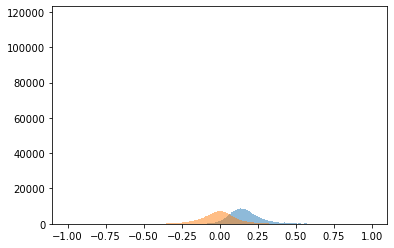

In [31]:
plt.hist(result_pos_dist.numpy(), bins=1000, alpha=0.5)
plt.hist(result_neg_dist.numpy(), bins=1000, alpha=0.5)
plt.show()

# Tests

## Test ``gen_pos_examples`` and ``gen_neg_examples``

Test whether all possible positive and negative examples are generated correctly and their counts are distributed evely.

In [15]:
from collections import Counter
from itertools import product

import numpy as np

In [16]:
def test_example_generators():
    n_rows = 1000000
    ix_sents = torch.tensor([[1, 2, 3, 0, 0], [4, 5, 6, 7, 8]]).repeat(n_rows // 2, 1)
    sent_lengths = ix_sents.sign().sum(dim=1)

    pos_bigram_ixs = gen_pos_bigram_ixs(ix_sents)
    neg_bigram_ixs = gen_neg_bigram_ixs(ix_sents)

    counter_pos_examples = Counter(tuple(pair) for pair in pos_bigram_ixs.numpy())
    counter_neg_examples = Counter(tuple(pair) for pair in neg_bigram_ixs.numpy())

    pos_examples_1 = {(1, 2), (2, 3)}
    neg_examples_1 = set(product([1, 2, 3], repeat=2)) - pos_examples_1
    pos_examples_2 = {(4, 5), (5, 6), (6, 7), (7, 8)}
    neg_examples_2 = set(product([4, 5, 6, 7, 8], repeat=2)) - pos_examples_2

    total_counts_pos_examples_1 = sum(
        [counter_pos_examples[pair] for pair in pos_examples_1]
    )
    total_counts_neg_examples_1 = sum(
        [counter_neg_examples[pair] for pair in neg_examples_1]
    )
    total_counts_pos_examples_2 = sum(
        [counter_pos_examples[pair] for pair in pos_examples_2]
    )
    total_counts_neg_examples_2 = sum(
        [counter_neg_examples[pair] for pair in neg_examples_2]
    )

    total_counts_pos_examples_1 == total_counts_neg_examples_1 == n_rows // 2
    total_counts_pos_examples_2 == total_counts_neg_examples_1 == n_rows // 2

    assert sum(counter_pos_examples.values()) == n_rows

    assert (
        np.std(
            [
                counter_pos_examples[pair] / total_counts_pos_examples_1
                for pair in pos_examples_1
            ]
        )
        < 0.01
    )

    assert (
        np.std(
            [
                counter_pos_examples[pair] / total_counts_neg_examples_1
                for pair in neg_examples_1
            ]
        )
        < 0.01
    )

    assert (
        np.std(
            [
                counter_pos_examples[pair] / total_counts_pos_examples_2
                for pair in pos_examples_2
            ]
        )
        < 0.01
    )

    assert (
        np.std(
            [
                counter_neg_examples[pair] / total_counts_neg_examples_2
                for pair in pos_examples_2
            ]
        )
        < 0.01
    )
    return True

In [17]:
test_example_generators()

True